# Imports

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

# Functions

In [2]:
def anglewrap(angList):
    # maps an 0 to 360 angle to -180 to +180
    for i in range(len(angList)):
        if (angList[i] > 180):
            angList[i] = angList[i] - 360
    return 

def wrap_to_pi(angle):
    # Better function to wrap angle
    return ((angle + np.pi) % (2 * np.pi)) - np.pi

In [3]:

def import_data(name: str, wrap = True, cleanup = True):
    file = name + ".csv"
    pdoa_data = []
    tdoa_data = []
    rx_true_r = []

    dist_meas = []
    twr_count = []
    dist_true_r = []

    with open(file, "r") as f:
        reader = csv.reader(f)
        for i, line in enumerate(reader):
            linetype = int(line[0])
            if (linetype == 0):
                # rx data, featuring pdoa, tdoa and distance
                pdoa_data += [float(line[1])]
                tdoa_data += [int(line[2])]
                rx_true_r += [float(line[3])]
            
            if (linetype == 1):
                dist_meas += [int(line[5])]
                twr_count += [int(line[6])]
                dist_true_r += [float(line[7])]

            if (linetype == 2):
                print("CIR data")
    
    if (wrap):
        # Wrap angles
        anglewrap(rx_true_r)
        anglewrap(dist_true_r)

    if (cleanup):
        # Remove extreme dist outliers:
        dist_keep_indx = [i > 1000 for i in dist_meas]
        dist_meas_filt = []
        dist_r_filt = []
        twr_count_filt = []

        out_num = 0

        for i in range(len(dist_keep_indx)):
            if dist_keep_indx[i] == True:
                dist_meas_filt += [dist_meas[i]]
                dist_r_filt += [dist_true_r[i]]
                twr_count_filt += [twr_count[i]]
            else:
                out_num += 1

        print("Num of outliers: " + str(out_num))
        # Update values
        dist_meas = dist_meas_filt
        dist_true_r = dist_r_filt
        twr_count = twr_count_filt
    
    return (pdoa_data, tdoa_data, rx_true_r, dist_meas, twr_count, dist_true_r)

# Prepare data

In [4]:
rx_true_r = []
pdoa_data = []
dist_true_r = []
dist_meas = []

# , "m1_to_m2_rot2", "m1_to_m2_rot", "m4_to_m1_rot", "m5_to_m1_rot"

# List of measurements:
files = ["new_rot5m", "m1_to_m2_rot2", "m1_to_m2_rot", "m4_to_m1_rot", "m5_to_m1_rot"]
log_num = len(files)
for log in files:
    temp_pdoa, _, temp_rx_r, temp_dist, _, temp_dist_r = import_data(log, True, False)
    rx_true_r += [temp_rx_r]
    pdoa_data += [temp_pdoa]
    dist_true_r += [temp_dist_r]
    dist_meas += [temp_dist]

# Plot data

C:\Users\marcu\AppData\Local\Temp\ipykernel_16020\3302768618.py:6: RuntimeWarning: invalid value encountered in arcsin
  pdoa2ang = lambda a : np.arcsin(((a-2*np.pi)*lam)/(2*np.pi*d))


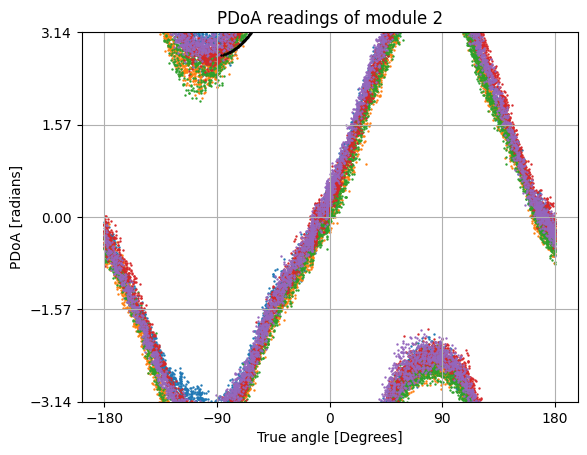

In [5]:
d = 0.026 # 0.0231      # Distance between antennas
f = 6.4896e9    # frequency
c = 299792458   # speed of light
lam = c/f       # wavelength

pdoa2ang = lambda a : np.arcsin(((a-2*np.pi)*lam)/(2*np.pi*d))
ang2pdoa = lambda a : np.sin(a)*(2*np.pi*d)/(lam)

dummy_pdoa = np.linspace(-np.pi,np.pi,1000)
dummy_ang = np.linspace(-np.pi,np.pi,2000)
ideal_ang = pdoa2ang(dummy_pdoa)*(180/np.pi) # in degrees
ideal_pdoa = wrap_to_pi(ang2pdoa(dummy_ang+8*(np.pi/180)))

plt.figure()
plt.title("PDoA readings of module 2")
for i in range(log_num):
    plt.scatter(rx_true_r[i], pdoa_data[i], s=0.5)
#plt.scatter(dummy_ang*(180/np.pi), ideal_pdoa, color='black', s=0.5)
plt.scatter(ideal_ang, dummy_pdoa, color='black',s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("PDoA [radians]")
plt.xticks([-180, -90, 0, 90, 180])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()



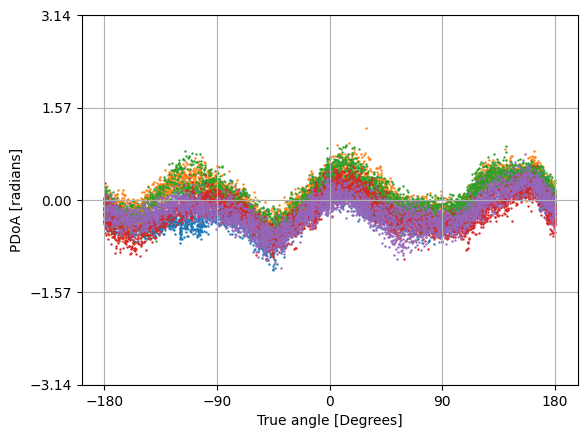

In [6]:
# Plot noise:

pdoa_error_cat = np.empty([0])

pdoa_error = []
for i in range(log_num):
    pdoa_ideal = wrap_to_pi(ang2pdoa( (np.array(rx_true_r[i])+8)*(np.pi/180) ))
    pdoa_error += [wrap_to_pi(pdoa_ideal - np.array(pdoa_data[i]))]
    pdoa_error_cat = np.append(pdoa_error_cat, pdoa_error[i]) # For finding the total variance

plt.figure()

for i in range(log_num):
    plt.scatter(rx_true_r[i], pdoa_error[i], s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("PDoA [radians]")
plt.xticks([-180, -90, 0, 90, 180])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()

In [7]:
# Variance of estimates

pdoa_var = np.var(pdoa_error_cat,axis=0)
pdoa_mean = np.mean(pdoa_error_cat,axis=0)
print(pdoa_var)
print(pdoa_mean*(180/np.pi))

3*np.sqrt(pdoa_var)*(180/np.pi)

0.09953791242632579
-4.093463908433127


54.22981853943913

In [46]:
# Piecewise function for PDoA

def pdoa2ang_piece(a):
    # Function for converting pdoa to angle - including all the possible ambiguities
    
    d = 0.026 # 0.0231      # Distance between antennas
    f = 6.4896e9    # frequency
    c = 299792458   # speed of light
    lam = c/f       # wavelength

    # The two thresholds
    rupp = -(2*np.pi*d)/lam + 2*np.pi
    rlow = (2*np.pi*d)/lam - 2*np.pi

    ang1 = np.arcsin((a*lam)/(2*np.pi*d))
    
    if a >= rupp:
        ang2 = np.arcsin(((a-2*np.pi)*lam)/(2*np.pi*d))
    elif a <= rlow:
        ang2 = np.arcsin(((a+2*np.pi)*lam)/(2*np.pi*d))
    else:
        # Simple case of only two ambiguities:
        mang = np.zeros(2)
        mang[0] = ang1
        mang[1] = wrap_to_pi(np.pi - ang1)

        return mang
    # More advanced case of four ambiguities:

    mang = np.zeros(4)
    mang[0] = ang1
    mang[1] = ang2
    mang[2] = wrap_to_pi(np.pi - ang1)
    mang[3] = wrap_to_pi(np.pi - ang2)

    return mang

def gen_adv_amb(a):
    
    d = 0.026 # 0.0231      # Distance between antennas
    f = 6.4896e9    # frequency
    c = 299792458   # speed of light
    lam = c/f       # wavelength
    
    pdoa = wrap_to_pi(np.sin(a)*(2*np.pi*d)/(lam)) # First generate the equivalent pdoa
    mang = pdoa2ang_piece(pdoa) # Then all the ambiguities
    return mang

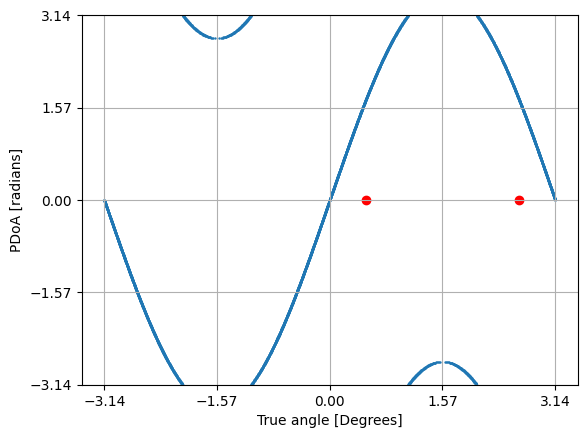

In [49]:
# Test piecewise function
dummy_pdoa = np.linspace(-np.pi,np.pi,2000)

pdoa2plot = np.empty([0])
angle2plot = np.empty([0])

for pdoa in dummy_pdoa:
    temp = pdoa2ang_piece(pdoa)
    
    angle2plot = np.append(angle2plot, temp)
    pdoa2plot = np.append(pdoa2plot, np.ones_like(temp)*pdoa)


# And then attempt to plot it:

plt.figure()
plt.scatter(angle2plot, pdoa2plot, s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("PDoA [radians]")
plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()

# Try to test the angle2multiamb function:
mang= gen_adv_amb(0.5)
pdoa = np.ones_like(mang)*0

plt.scatter(mang, pdoa, color='red')

